In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# 1. Data Loader

In [20]:
class MigrationData:
    
    """
    Loads and validates the migration CSV dataset.

    Required columns:
    - country_from
    - country_to
    - migration_month
    - num_migrants
    """

    def __init__(self, filepath):
        self.filepath = filepath
        self.required_columns = [
            'country_from',
            'country_to',
            'migration_month',
            'num_migrants'
        ]

    def load_data(self):
        try:
            df = pd.read_csv(self.filepath)

            missing_cols = [col for col in self.required_columns if col not in df.columns]
            if missing_cols:
                print(f"Error: The dataset is missing the following required columns: {missing_cols}")
                return None

            print("Dataset loaded and validated successfully!")
            return df

        except FileNotFoundError:
            print(f"Error: The file '{self.filepath}' could not be found. Please check the path.")
            return None

        except Exception as e:
            print(f"An unexpected error occurred while loading the data: {e}")
            return None

In [12]:
#Task 1 - Output
migration_file = "international_migration_flow.csv"
loader = MigrationData(migration_file)
df = loader.load_data()
print(df.head())

Dataset loaded and validated successfully!
  country_from country_to migration_month  num_migrants
0           AD         AE         2019-01            12
1           AD         AE         2019-02             2
2           AD         AE         2019-03             1
3           AD         AE         2019-04             7
4           AD         AE         2019-05             0


# 2. Monthly Network Builder

In [22]:
class TemporalNetwork:

    """
    Builds directed weighted migration networks for each month.
    """

    def __init__(self, dataframe):
        self.df = dataframe

    def build_monthly_networks(self):
        """
        Returns
        -------
        dict
            {month_key: networkx.DiGraph}
        """
        monthly_networks = {}

        grouped_data = self.df.groupby('migration_month')

        for month, group in grouped_data:
            G = nx.DiGraph()

            for _, row in group.iterrows():
                source = row['country_from']
                target = row['country_to']
                weight = row['num_migrants']

                if weight > 0:
                    G.add_edge(source, target, weight=weight)

            monthly_networks[month] = G

        print(f"\nSuccessfully constructed networks for {len(monthly_networks)} months.")
        return monthly_networks

In [14]:
#Task 2 - Output
network_constructor = TemporalNetwork(df)
monthly_networks_dict = network_constructor.build_monthly_networks()

sample_month = list(monthly_networks_dict.keys())[0]
sample_graph = monthly_networks_dict[sample_month]

print(f"\nInspection for month: {sample_month}")
print(f"Total Nodes (Countries): {sample_graph.number_of_nodes()}")
print(f"Total Edges (Migration Flows): {sample_graph.number_of_edges()}")

sample_edges = list(sample_graph.edges(data=True))[:5]
print(f"Sample Edges: {sample_edges}")


Successfully constructed networks for 48 months.

Inspection for month: 2019-01
Total Nodes (Countries): 181
Total Edges (Migration Flows): 20037
Sample Edges: [('AD', 'AE', {'weight': 12}), ('AD', 'AM', {'weight': 11}), ('AD', 'AR', {'weight': 11}), ('AD', 'AT', {'weight': 5}), ('AD', 'AU', {'weight': 10})]


# 3. Centrality Analyzer

In [ ]:
class CentralityAnalyzer:

    """
    Computes PageRank, Betweenness, and Centralization over time.
    """

    def __init__(self, monthly_networks: dict):
        self.monthly_networks = monthly_networks
        self.months = sorted(list(monthly_networks.keys()))
        self.all_countries = self._get_all_countries()

    def _get_all_countries(self):
        countries = set()
        for G in self.monthly_networks.values():
            for n in G.nodes():
                if isinstance(n, str) and n.strip() != "":
                    countries.add(n)
        return sorted(countries)

    def _to_time_df(self, series_by_month: dict, fill_value=0.0):
        df = pd.DataFrame(index=self.months, columns=self.all_countries, dtype=float)
        for month, node_dict in series_by_month.items():
            for node, val in node_dict.items():
                df.loc[month, node] = val
        return df.fillna(fill_value)

    # PageRank
    def compute_pagerank_over_time(self, weight="weight", alpha=0.85):
        pr_by_month = {}
        for month, G in self.monthly_networks.items():
            if G.number_of_nodes() == 0:
                pr_by_month[month] = {}
            else:
                pr_by_month[month] = nx.pagerank(G, alpha=alpha, weight=weight)
        return self._to_time_df(pr_by_month, fill_value=0.0)

    # Betweenness
    def compute_betweenness_over_time(self, normalized=True):
        bt_by_month = {}
        for month, G in self.monthly_networks.items():
            if G.number_of_nodes() == 0:
                bt_by_month[month] = {}
            else:
                bt_by_month[month] = nx.betweenness_centrality(G, normalized=normalized)
        return self._to_time_df(bt_by_month, fill_value=0.0)

    # Centralization
    def compute_centralization_over_time(self, metric="pagerank", weight="weight", alpha=0.85):
        centralization = {}
        for month, G in self.monthly_networks.items():
            if metric.lower() == "pagerank":
                c = nx.pagerank(G, alpha=alpha, weight=weight)
            elif metric.lower() == "betweenness":
                c = nx.betweenness_centrality(G, normalized=True)
            else:
                raise ValueError("metric must be 'pagerank' or 'betweenness'")

            vals = list(c.values())
            total = sum(vals)
            centralization[month] = (max(vals) / total) if total != 0 else 0.0

        return pd.Series(centralization).sort_index()

    # Top countries
    def top_countries(self, centrality_df: pd.DataFrame, k=10, method="mean"):
        if method == "mean":
            scores = centrality_df.mean(axis=0)
        elif method == "sum":
            scores = centrality_df.sum(axis=0)
        elif method == "last":
            scores = centrality_df.iloc[-1]
        else:
            raise ValueError("method must be 'mean', 'sum', or 'last'")

        return scores.sort_values(ascending=False).head(k).index.tolist()

In [16]:
#Task 3 - Outputs
analyzer = CentralityAnalyzer(monthly_networks_dict)

pagerank_df = analyzer.compute_pagerank_over_time()
betweenness_df = analyzer.compute_betweenness_over_time()
centralization_series = analyzer.compute_centralization_over_time(metric="pagerank")

top_pagerank = analyzer.top_countries(pagerank_df, k=10, method="mean")
top_betweenness = analyzer.top_countries(betweenness_df, k=10, method="mean")

pagerank_df.head(), betweenness_df.head(), centralization_series.head(), top_pagerank, top_betweenness

(               AD        AE        AF        AL        AM        AO        AR  \
 2019-01  0.001293  0.026686  0.003411  0.002112  0.002904  0.002644  0.005912   
 2019-02  0.001244  0.026681  0.003302  0.002031  0.002086  0.002574  0.005920   
 2019-03  0.001200  0.025473  0.002859  0.002135  0.002101  0.002460  0.005175   
 2019-04  0.001275  0.022892  0.003491  0.002104  0.002132  0.002339  0.004481   
 2019-05  0.001292  0.022500  0.003326  0.002219  0.002442  0.002492  0.004355   
 
                AT        AU        AZ  ...        VE        VN        VU  \
 2019-01  0.005265  0.023744  0.002461  ...  0.003924  0.015204  0.001352   
 2019-02  0.005289  0.025762  0.002360  ...  0.003366  0.014393  0.001273   
 2019-03  0.005214  0.019457  0.002200  ...  0.003184  0.016823  0.001188   
 2019-04  0.006378  0.014473  0.002159  ...  0.003718  0.016388  0.001126   
 2019-05  0.005498  0.014263  0.002210  ...  0.004286  0.015383  0.001227   
 
                WS        XK        YE    

In [17]:
#Task 4
def pagerank_evolution(pagerank_df,top_pagerank):
  plt.figure(figsize=(12,6))
  for country in top_pagerank:
    plt.plot(pagerank_df.index, pagerank_df[country], label=country)
  plt.title(f"Evolution of PageRank Over Time")
  plt.xlabel("Month")
  plt.ylabel("PageRank")
  plt.xticks(rotation=45)
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
  plt.tight_layout()
  plt.show()

def centralization_evolution(centralization_series):
  plt.figure(figsize=(12,6))
  plt.plot(centralization_series.index, centralization_series.values)
  plt.title("Network Centralization Over Time")
  plt.xlabel("Month")
  plt.ylabel("Centralization")
  plt.xticks(rotation=45)
  plt.grid(True, linestyle='--', alpha=0.5)
  plt.tight_layout()
  plt.show()

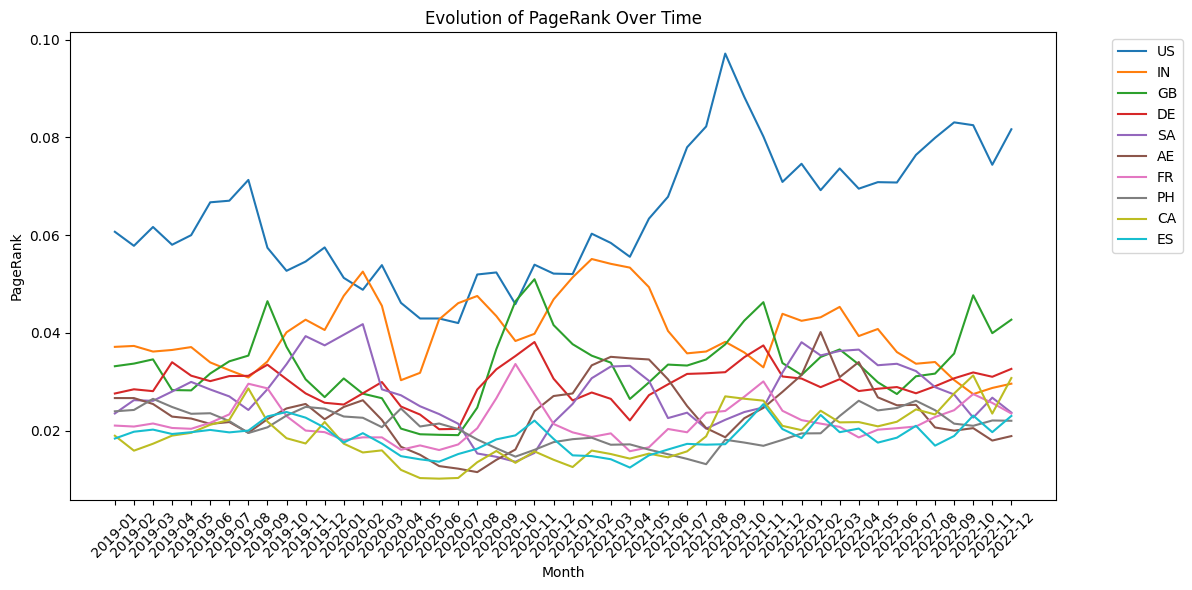

In [18]:
#Task 4 - Output 1
pagerank_evolution(pagerank_df,top_pagerank)

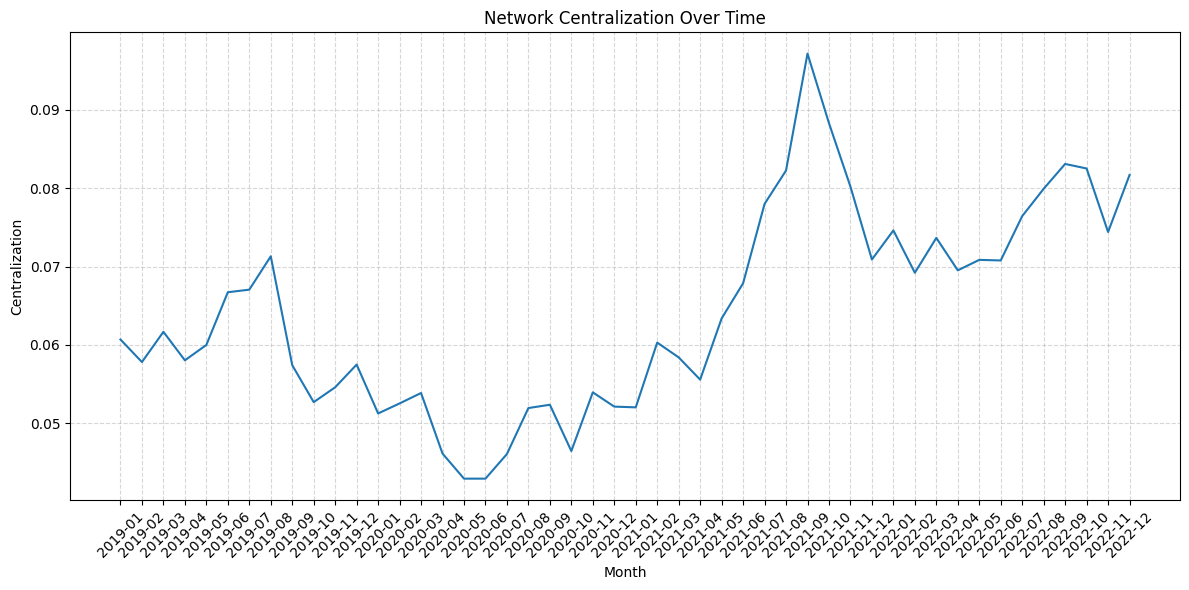

In [19]:
#Task 4 - Output 2
centralization_evolution(centralization_series)